In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import cv2 as cv
import os
import h5py
import matplotlib.pyplot as plt
import scipy.misc
import scipy.ndimage

from tqdm import tqdm
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Convolution2D, Deconvolution2D, merge
from keras.layers.core import Activation, Dropout, Flatten, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras import objectives, layers
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import cv2
from PIL import Image
from scipy.misc import imresize


Using TensorFlow backend.


In [2]:

np.random.seed(1337)  # for reproducibility

In [3]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg = Model(input=base_model.input, output=base_model.get_layer('block2_conv2').output)

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  


In [4]:
# def load_file_names(path):
#     return os.listdir(path)

In [5]:
def imshow(x, gray=False):
    plt.imshow(x, cmap='gray' if gray else None)
    plt.show()

In [6]:
def get_features(Y):
    Z = deepcopy(Y)
    Z = preprocess_vgg(Z)
    features = vgg.predict(Z, batch_size = 5, verbose = 0)
    return features

In [7]:
def preprocess_vgg(x, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    x = 255. * x
    if data_format == 'channels_first':
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] = x[:, 0, :, :] - 103.939
        x[:, 1, :, :] = x[:, 1, :, :] - 116.779
        x[:, 2, :, :] = x[:, 2, :, :] - 123.68
    else:
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
        # Zero-center by mean pixel
        x[:, :, :, 0] = x[:, :, :, 0] - 103.939
        x[:, :, :, 1] = x[:, :, :, 1] - 116.779
        x[:, :, :, 2] = x[:, :, :, 2] - 123.68
    return x

In [8]:
def feature_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def pixel_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) + 0.00001*total_variation_loss(y_pred)

def adv_loss(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

def total_variation_loss(y_pred):
    if K.image_data_format() == 'channels_first':
        a = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, 1:, :n - 1])
        b = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, :m - 1, 1:])
    else:
        a = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, 1:, :n - 1, :])
        b = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, :m - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
def preprocess_VGG(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}
    # x has pixels intensities between 0 and 1
    x = 255. * x
    norm_vec = K.variable([103.939, 116.779, 123.68])
    if dim_ordering == 'th':
        norm_vec = K.reshape(norm_vec, (1,3,1,1))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        norm_vec = K.reshape(norm_vec, (1,1,1,3))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x

In [10]:
def generator_model(input_img):

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.add([x, res])

    # Decoder
    res = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1')(encoded)
    x = layers.add([encoded, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(128, (2, 2), activation='relu', padding='same', name='block6_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(x)
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(64, (2, 2), activation='relu', padding='same', name='block8_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block9_conv1')(x)
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(32, (2, 2), activation='relu', padding='same', name='block10_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block11_conv1')(x)
    res = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return decoded

In [11]:
def feat_model(img_input):
    # extract vgg feature
    vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None)
    # freeze VGG_16 when training
    for layer in vgg_16.layers:
        layer.trainable = False
    
    vgg_first2 = Model(input=vgg_16.input, output=vgg_16.get_layer('block2_conv2').output)
    Norm_layer = Lambda(preprocess_VGG)
    x_VGG = Norm_layer(img_input)
    feat = vgg_first2(x_VGG)
    return feat

In [12]:
def full_model():
    input_img = Input(shape=(m, n, 1))
    generator = generator_model(input_img)
    feat = feat_model(generator)
    model = Model(input=input_img, output=[generator, feat], name='architect')
    return model

In [13]:
def compute_vgg():
    base_model = vgg16.VGG16(weights='imagenet', include_top=False)
    model = Model(input=base_model.input, output=base_model.get_layer('block2_conv2').output)
    num_batches = num_images // batch_size
    for batch in range(num_batches):
        _, Y = get_batch(batch, X = False);
        Y = preprocess_vgg(Y)
        features = model.predict(Y, verbose = 1)
        f = h5py.File('features/feat_%d' % batch, "w")
        dset = f.create_dataset("features", data=features)

In [14]:
m = 200
n = 200
sketch_dim = (m,n)
img_dim = (m, n,3)
model = full_model()
optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss=[pixel_loss, feature_loss], loss_weights=[1, 1], optimizer=optim)
model.load_weights('../newWeights/weights_77')

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  
C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso..., name="architect")`
  """


In [15]:
def predictAndPlot(input_path, label_path):
    m = 200
    n = 200
    sketch_dim = (m,n)
    img_dim = (m, n,3)
    sketch = cv.imread(input_path, 0)
    sketch = imresize(sketch, sketch_dim)
    sketch = sketch / 255.
    sketch = sketch.reshape(1,m,n,1)
    actual = cv.imread(label_path)
    actual = imresize(actual, img_dim)
    result, _ = model.predict(sketch) 
    #### Plotting ####
    fig = plt.figure()
    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
    a.set_title('Sketch')
    plt.axis("off")
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(result[0])
    a.set_title('Prediction')
    plt.axis("off")
    a = fig.add_subplot(1,3,3)
    plt.imshow(cv2.cvtColor(actual, cv2.COLOR_BGR2RGB))
    a.set_title('label')
    plt.axis("off")
    plt.show()

In [16]:
#predictAndPlot('rsketch/f1-001-01-sz1.jpg','rphoto/f1-001-01.jpg')

In [23]:
def predictAndPlot2(input_path, label_path, num_images, trunc = 4):
    count = 0;
    m = 200
    n = 200
    sketch_dim = (m,n)
    img_dim = (m, n,3)
    for file in os.listdir(input_path):
        print(file)
        sketch = cv.imread(str(input_path + '/' + file), 0)
        print(sketch.shape)
        sketch = imresize(sketch, sketch_dim)
        sketch = sketch / 255.
        sketch = sketch.reshape(1,m,n,1)
        actual = cv.imread(str(label_path + '/' + file[:-trunc] + '.jpg'))
        print(str(label_path + '/' + file[:-trunc]))
        actual = imresize(actual, img_dim)
        result, _ = model.predict(sketch)
        fig = plt.figure()
        a = fig.add_subplot(1,3,1)
        imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
        a.set_title('Sketch')
        plt.axis("off")
        a = fig.add_subplot(1,3,2)
        imgplot = plt.imshow(result[0])
#         write_path1 = str('../images/prediction/' + file )
#         plt.imsave(write_path1, result[0])

#         write_path = str('../images/qp/' + file )
        a.set_title('Prediction')
        plt.axis("off")
        a = fig.add_subplot(1,3,3)
        act2 = cv2.cvtColor(actual, cv2.COLOR_BGR2RGB) 
#         plt.imsave(write_path, act2)

        plt.imshow(cv2.cvtColor(actual, cv2.COLOR_BGR2RGB))
        
        a.set_title('label')
        plt.axis("off")
        plt.show()
        count += 1
        if(count == num_images):
            break

Angelina_Jolie_0014.jpg
(200, 200)
../qdata/Angelina_Jolie_0014


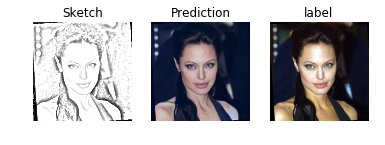

Arnold_Schwarzenegger_0037.jpg
(200, 200)
../qdata/Arnold_Schwarzenegger_0037


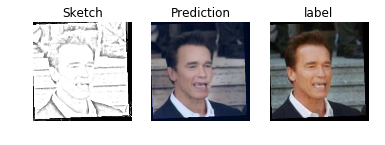

Bill_Gates_0003.jpg
(200, 200)
../qdata/Bill_Gates_0003


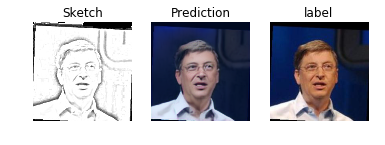

f1-004-01.jpg
(200, 200)
../qdata/f1-004-01


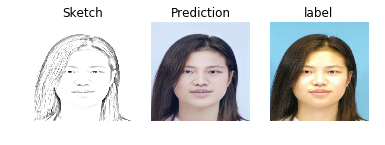

Jim_Carrey_0002.jpg
(200, 200)
../qdata/Jim_Carrey_0002


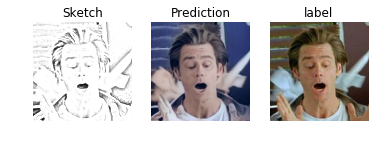

Morgan_Freeman_0001.jpg
(200, 200)
../qdata/Morgan_Freeman_0001


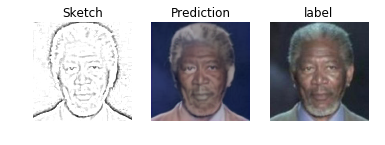

Tom_Cruise_0006.jpg
(200, 200)
../qdata/Tom_Cruise_0006


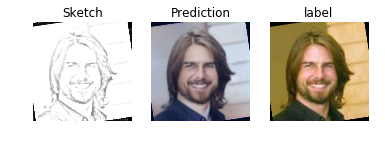

Tom_Hanks_0005.jpg
(200, 200)
../qdata/Tom_Hanks_0005


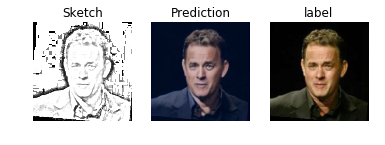

In [25]:
predictAndPlot2('../sdata', '../qdata',12)

000340.jpg
(200, 200)
../pdata3/000340


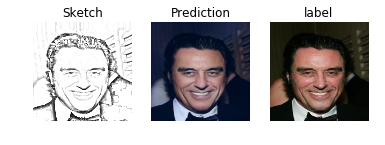

000370.jpg
(200, 200)
../pdata3/000370


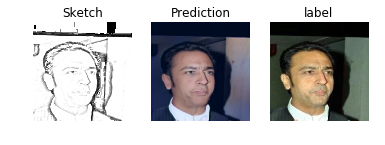

koul.jpg
(200, 200)
../pdata3/koul


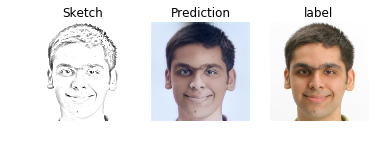

obama.jpg
(200, 200)
../pdata3/obama


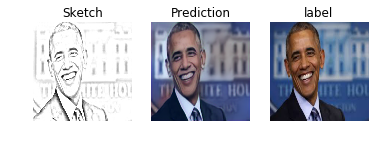

In [30]:
predictAndPlot2('../sdata3', '../pdata3',4)